<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение
### Семинар 5. Оценивание качества модели и подбор параметров

<br />
<br />
30 сентября 2021

### Подбор параметров в регрессии

Для примера будем использовать случайный полином от трёх переменных


In [45]:
import numpy as np

power = 5

def str_monomial(monomial):
    pow_x = monomial % power
    monomial //= power
    pow_y = monomial % power
    monomial //= power
    pow_z = monomial
    return f"x**{pow_x}*y**{pow_y}*z**{pow_z}"

def calc_monomial(monomial, x, y, z):
    pow_x = monomial % power
    monomial //= power
    pow_y = monomial % power
    monomial //= power
    pow_z = monomial
    return x**pow_x * y**pow_y * z**pow_z

class Polynomial:
    def __init__(self, num_monomials):
        self.monomials = np.random.randint(0, power**3, num_monomials)
        self.coefs = np.random.random(num_monomials)

    def to_str(self):
        monomials = [f"{c:.1f}*{str_monomial(m)}" for m, c in zip(self.monomials, self.coefs)]
        print(" + ".join(monomials))

    def __call__(self, x, y, z):
        return np.array([c * calc_monomial(m, x, y, z) for m, c in zip(self.monomials, self.coefs)]).sum(axis=0)
    

In [46]:
poly = Polynomial(5)
poly.to_str()

0.3*x**3*y**4*z**3 + 0.3*x**1*y**1*z**0 + 0.7*x**3*y**0*z**3 + 0.4*x**2*y**3*z**3 + 0.4*x**0*y**0*z**1


#### Тренировочный датасет

In [47]:
xs = np.random.uniform(-2, 2, 500)
ys = np.random.uniform(-2, 2, 500)
zs = np.random.uniform(-2, 2, 500)

In [48]:
X = np.vstack([calc_monomial(m, xs, ys, zs) for m in range(power**3)]).T

In [49]:
X.shape

(500, 125)

In [50]:
y = poly(xs, ys, zs) + np.random.normal(loc = 0.0, scale = 2.0, size=500)

#### И тестовый датасет

In [51]:
xs_test = np.random.uniform(3, 4, 50)
ys_test = np.random.uniform(-4, -3, 50)
zs_test = np.random.uniform(-3, -2, 50)

In [52]:
X_test = np.vstack([calc_monomial(m, xs_test, ys_test, zs_test) for m in range(power**3)]).T

In [53]:
X_test.shape

(50, 125)

In [54]:
y_test=poly(xs_test, ys_test, zs_test)

### Линейная регрессия

In [55]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV

In [56]:
round(cross_val_score(LinearRegression(), X, y, cv=5).mean(), ndigits=5)

0.96902

Даже на кроссвалидации результат далек от отличного:
    
----
[Документация score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=score#sklearn.linear_model.LinearRegression.score)

Коэффициент $R^2 = 1 - \frac{u}{v}$

$u = ((y\_true - y\_pred)^2).sum()$

$v = ((y\_true - y\_true.mean())^2).sum()$


In [57]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.score(X_test, y_test)

-57.4429519360437

Тестовые данные в другой области, поэтому результат там еще хуже.

Посмотрим 10 самых больших по модулю коэффициентов и выведем их:

In [58]:
ind = np.array(np.abs(lin_reg.coef_)).argpartition(-10)[-10:]
ind

array([16, 52, 26, 51, 31, 12, 37,  6, 62,  0], dtype=int64)

In [59]:
for m in ind:
    print(f"{lin_reg.coef_[m]:.1f} {str_monomial(m)}")

-1.6 x**1*y**3*z**0
2.1 x**2*y**0*z**2
-1.6 x**1*y**0*z**1
1.8 x**1*y**0*z**2
2.4 x**1*y**1*z**1
1.7 x**2*y**2*z**0
3.6 x**2*y**2*z**1
3.0 x**1*y**1*z**0
-3.6 x**2*y**2*z**2
1583449595162.4 x**0*y**0*z**0


In [60]:
poly.to_str()

0.3*x**3*y**4*z**3 + 0.3*x**1*y**1*z**0 + 0.7*x**3*y**0*z**3 + 0.4*x**2*y**3*z**3 + 0.4*x**0*y**0*z**1


#### Поможет ли регуляризация?

In [61]:
param_grid = [{'alpha': [1e-3, 1e-2, 1e-1, 1.0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11]}]
ridge_searcher = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_searcher.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,
                                    10000.0, 100000.0, 1000000.0, 10000000.0,
                                    100000000.0, 1000000000.0, 10000000000.0,
                                    100000000000.0]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [62]:
import pandas as pd

pd.DataFrame(ridge_searcher.cv_results_).sort_values("mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.001197,0.000399,0.000826,0.000416,1e+09,{'alpha': 1000000000.0},-0.024923,-0.012345,-0.062617,-0.004878,-0.003265,-0.021606,0.021886,15
11,0.001218,0.000390,0.000598,0.000489,1e+08,{'alpha': 100000000.0},-0.035633,0.063401,-0.170182,0.029047,0.007055,-0.021263,0.081098,14
13,0.001415,0.000512,0.000601,0.000490,1e+10,{'alpha': 10000000000.0},-0.021897,-0.020858,-0.049444,-0.007644,-0.003573,-0.020683,0.016071,13
14,0.000998,0.000001,0.000620,0.000508,1e+11,{'alpha': 100000000000.0},-0.021569,-0.021720,-0.048097,-0.007912,-0.003595,-0.020579,0.015546,12
10,0.001414,0.000513,0.000600,0.000490,1e+07,{'alpha': 10000000.0},0.250214,0.410541,-0.485112,0.340465,0.231954,0.149612,0.323816,11
9,0.001614,0.000504,0.000602,0.000492,1e+06,{'alpha': 1000000.0},0.853219,0.809056,-0.070365,0.767786,0.781099,0.628159,0.350485,10
8,0.001475,0.000449,0.000598,0.000489,100000,{'alpha': 100000.0},0.964071,0.928335,0.848614,0.953823,0.926402,0.924249,0.040503,9
7,0.001224,0.000449,0.000597,0.000487,10000,{'alpha': 10000.0},0.986459,0.963507,0.984678,0.987645,0.969752,0.978408,0.009863,8
0,0.002990,0.000631,0.001199,0.000982,0.001,{'alpha': 0.001},0.983696,0.966748,0.993073,0.987786,0.986733,0.983607,0.008956,7
1,0.001789,0.000744,0.000605,0.000494,0.01,{'alpha': 0.01},0.983729,0.966827,0.993096,0.987905,0.986758,0.983663,0.008944,6


In [63]:
ridge_reg = ridge_searcher.best_estimator_

Результат заметно лучше!

In [64]:
ridge_reg.score(X_test, y_test)

0.8622076201433861

Посмотрим, какие мономы были отобраны теперь:

In [67]:
ind = np.array(np.abs(ridge_reg.coef_)).argpartition(-6)[-6:]
ind

array([ 6, 81, 65, 92, 98, 78], dtype=int64)

In [68]:
for m in ind:
    print(f"{lin_reg.coef_[m]:.1f} {str_monomial(m)}")

3.0 x**1*y**1*z**0
-0.7 x**1*y**1*z**3
-0.1 x**0*y**3*z**2
0.2 x**2*y**3*z**3
0.3 x**3*y**4*z**3
0.4 x**3*y**0*z**3


In [69]:
poly.to_str()

0.3*x**3*y**4*z**3 + 0.3*x**1*y**1*z**0 + 0.7*x**3*y**0*z**3 + 0.4*x**2*y**3*z**3 + 0.4*x**0*y**0*z**1


Из ответа в ТОП-6 уже попали первые четыре из пяти.

#### Отбор признаков можно делать с помощью Лассо

In [70]:
param_grid = [{'alpha': [1e-3, 1e-2, 1e-1, 1.0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}]
lasso_searcher = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_searcher.fit(X, y)

C:\Users\avalur\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.9573687406522, tolerance: 28.55338104995496
  positive)
C:\Users\avalur\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 649.1927569897489, tolerance: 36.18011727214726
  positive)
C:\Users\avalur\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.097816202288, tolerance: 25.165947617340958
  positive)
C:\Users\avalur\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0,
                                    10000.0, 100000.0, 1000000.0,
                                    10000000.0]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [71]:
pd.DataFrame(lasso_searcher.cv_results_).sort_values("mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.001012,2.968555e-05,0.000399,4.888697e-04,10000,{'alpha': 10000.0},-0.021533,-0.021816,-0.047947,-0.007942,-0.003597,-0.020567,0.015489,8
8,0.001197,3.987573e-04,0.000645,5.331368e-04,100000,{'alpha': 100000.0},-0.021533,-0.021816,-0.047947,-0.007942,-0.003597,-0.020567,0.015489,8
9,0.000813,4.076974e-04,0.000599,4.890840e-04,1e+06,{'alpha': 1000000.0},-0.021533,-0.021816,-0.047947,-0.007942,-0.003597,-0.020567,0.015489,8
10,0.001012,2.885673e-05,0.000598,4.883832e-04,1e+07,{'alpha': 10000000.0},-0.021533,-0.021816,-0.047947,-0.007942,-0.003597,-0.020567,0.015489,8
6,0.001214,4.320396e-04,0.000399,4.885192e-04,1000,{'alpha': 1000.0},0.417315,0.603484,-0.753077,0.627169,0.423002,0.263578,0.515824,7
5,0.000998,8.313940e-07,0.001020,4.649517e-05,100,{'alpha': 100.0},0.938347,0.865501,0.950291,0.964175,0.903246,0.924312,0.035675,6
4,0.003188,4.004782e-04,0.000998,6.743496e-07,10,{'alpha': 10.0},0.990992,0.957849,0.991427,0.990772,0.981657,0.982539,0.012873,5
0,0.031757,4.379444e-03,0.000814,4.102355e-04,0.001,{'alpha': 0.001},0.988021,0.971295,0.983694,0.993116,0.987455,0.984716,0.007351,4
1,0.031310,5.579778e-03,0.000399,4.890457e-04,0.01,{'alpha': 0.01},0.989201,0.976505,0.984072,0.993680,0.988705,0.986432,0.005822,3
2,0.024108,2.654760e-03,0.000411,5.036862e-04,0.1,{'alpha': 0.1},0.992821,0.977667,0.990486,0.994845,0.991737,0.989511,0.006093,2


Результат стал ещё лучше:

In [72]:
lasso_reg = lasso_searcher.best_estimator_
lasso_reg.score(X_test, y_test)

0.9997638418566644

Посмотрим, сколько параметров осталось после лассо регрессии:

In [73]:
np.count_nonzero(lasso_reg.coef_)

16

При этом коэфициенты монов всё ещё далеки от заданных нами:

In [74]:
lasso_ind = np.array(np.abs(lasso_reg.coef_)).argpartition(-8)[-8:]
lasso_ind

array([ 23,  19,  94,  95,  92,  78,  98, 116], dtype=int64)

In [75]:
for m in ind:
    print(f"{lin_reg.coef_[m]:.1f} {str_monomial(m)}")

3.0 x**1*y**1*z**0
-0.7 x**1*y**1*z**3
-0.1 x**0*y**3*z**2
0.2 x**2*y**3*z**3
0.3 x**3*y**4*z**3
0.4 x**3*y**0*z**3


In [76]:
poly.to_str()

0.3*x**3*y**4*z**3 + 0.3*x**1*y**1*z**0 + 0.7*x**3*y**0*z**3 + 0.4*x**2*y**3*z**3 + 0.4*x**0*y**0*z**1


#### Отобор признаков с помощью прохода вперед (Add)

In [77]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

forward_feature_selector = sfs(LinearRegression(), k_features="parsimonious", cv=5)
forward_feature_selector.fit(X, y)

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          fixed_features=None, floating=False, forward=True,
                          k_features='parsimonious', n_jobs=1,
                          pre_dispatch='2*n_jobs', scoring=None, verbose=0)

In [79]:
forward_feature_selector.k_feature_idx_

(78, 82, 92, 98)

In [80]:
pd.DataFrame(forward_feature_selector.subsets_.values())

,feature_idx,cv_scores,avg_score,feature_names
0,"(98,)","[0.8831931162135032, 0.7883122763628012, 0.929...",0.876303,"(98,)"
1,"(82, 98)","[0.9546687910214561, 0.9200366995526449, 0.974...",0.947925,"(82, 98)"
2,"(78, 82, 98)","[0.9855311455346851, 0.9694863187675029, 0.991...",0.982238,"(78, 82, 98)"
3,"(78, 82, 92, 98)","[0.9949614179494164, 0.980114236760324, 0.9964...",0.991331,"(78, 82, 92, 98)"
4,"(25, 78, 82, 92, 98)","[0.9951067860450967, 0.9803593531363889, 0.996...",0.991807,"(25, 78, 82, 92, 98)"
...,...,...,...,...
120,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9832399434729854, 0.9671692065499413, 0.993...",0.983959,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
121,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9837525106433415, 0.7863035687316059, 0.993...",0.947853,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
122,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9837409891088742, 0.8658859763955332, 0.993...",0.958676,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
123,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9785438334760784, 0.9677519580254338, 0.993...",0.971590,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [81]:
pd.DataFrame(forward_feature_selector.subsets_.values()).sort_values("avg_score")

,feature_idx,cv_scores,avg_score,feature_names
0,"(98,)","[0.8831931162135032, 0.7883122763628012, 0.929...",0.876303,"(98,)"
121,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9837525106433415, 0.7863035687316059, 0.993...",0.947853,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,"(82, 98)","[0.9546687910214561, 0.9200366995526449, 0.974...",0.947925,"(82, 98)"
122,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9837409891088742, 0.8658859763955332, 0.993...",0.958676,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
124,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9836919399416533, 0.9218382708179237, 0.993...",0.969023,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...
35,"(0, 6, 10, 11, 13, 17, 20, 25, 26, 31, 33, 34,...","[0.9950042435877028, 0.9827118979887989, 0.996...",0.992395,"(0, 6, 10, 11, 13, 17, 20, 25, 26, 31, 33, 34,..."
38,"(0, 6, 10, 11, 13, 17, 18, 20, 22, 25, 26, 31,...","[0.9949155027949108, 0.9827443544868827, 0.996...",0.992401,"(0, 6, 10, 11, 13, 17, 18, 20, 22, 25, 26, 31,..."
36,"(0, 6, 10, 11, 13, 17, 20, 25, 26, 31, 32, 33,...","[0.9950076963865815, 0.9827261750378526, 0.996...",0.992404,"(0, 6, 10, 11, 13, 17, 20, 25, 26, 31, 32, 33,..."
37,"(0, 6, 10, 11, 13, 17, 18, 20, 25, 26, 31, 32,...","[0.9949245074259483, 0.9827532544984885, 0.996...",0.992405,"(0, 6, 10, 11, 13, 17, 18, 20, 25, 26, 31, 32,..."


In [82]:
X_forward_selected = X[:, forward_feature_selector.k_feature_idx_]
forward_selected_reg = LinearRegression()
forward_selected_reg.fit(X_forward_selected, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
poly.to_str()

0.3*x**3*y**4*z**3 + 0.3*x**1*y**1*z**0 + 0.7*x**3*y**0*z**3 + 0.4*x**2*y**3*z**3 + 0.4*x**0*y**0*z**1


In [84]:
for coef, m in list(zip(forward_selected_reg.coef_, forward_feature_selector.k_feature_idx_)):
    print(f"{coef:.1f} {str_monomial(m)}")

0.7 x**3*y**0*z**3
0.0 x**2*y**1*z**3
0.4 x**2*y**3*z**3
0.3 x**3*y**4*z**3


In [85]:
forward_selected_reg.score(X_test[:,  forward_feature_selector.k_feature_idx_], y_test)

0.9998931816668009

Результат говорит сам за себя.

В `sklearn` тоже реализован отбор признаков по корелляции (и несколько других, не зависящих от модели), но они будут нам малополезны в данной задаче:

In [88]:
from sklearn.feature_selection import SelectKBest, f_regression
kbest_selector = SelectKBest(f_regression, k=5)
kbest_selector.fit(X, y)

C:\Users\avalur\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\avalur\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


SelectKBest(k=5, score_func=<function f_regression at 0x0000017D1A568048>)

In [89]:
X_kbest = kbest_selector.transform(X)

kbest_selected_reg = LinearRegression()
kbest_selected_reg.fit(X_kbest, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
X_kbest_test =kbest_selector.transform(X_test)
kbest_selected_reg.score(X_kbest_test, y_test)

-0.29026249761653644

### ROC кривая

По сложившейся традиции вернёмся к классификации ирисов.

In [47]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

Оставим только параметры чашелистика и будем классифицировать виргинские ирисы:

In [48]:
y[y == 2] = 0
X = X[:, :2]
features = np.array(["длина чашелистика", "ширина чашелистика"])
labels = np.array(["не виргинский", "виргинский"])

In [49]:
def show_legend():
    cb = plt.colorbar()
    loc = [0, 1]
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)

Разобьем датасет на тестовую и тренировочную части:

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=30, 
                                                    random_state=0)

#### Тренировочная часть

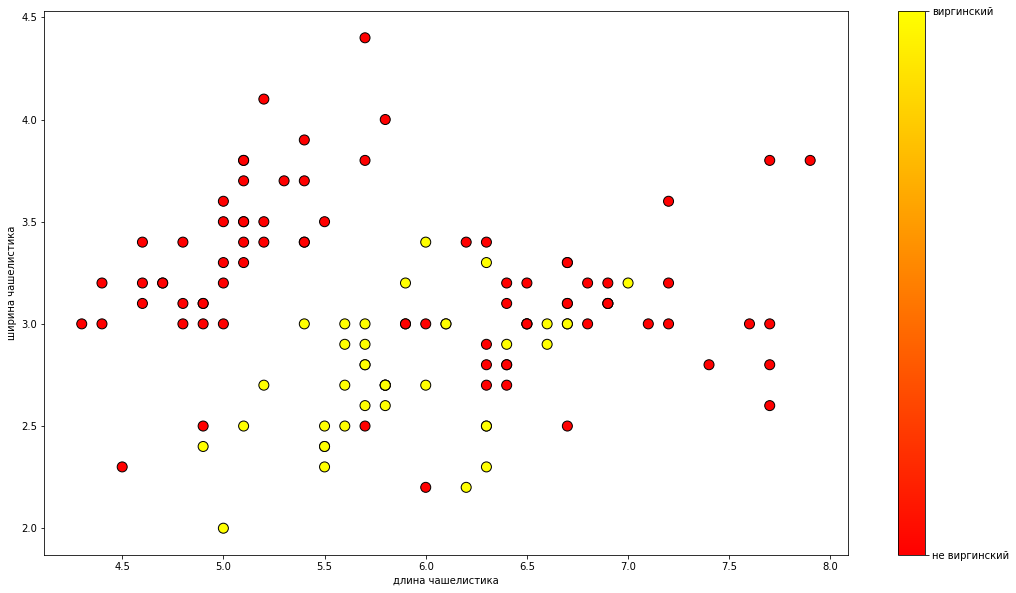

In [51]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(18.0, 10.0))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap='autumn', edgecolors="black")
plt.xlabel(features[0])
plt.ylabel(features[1])
show_legend()

#### Тестовая часть

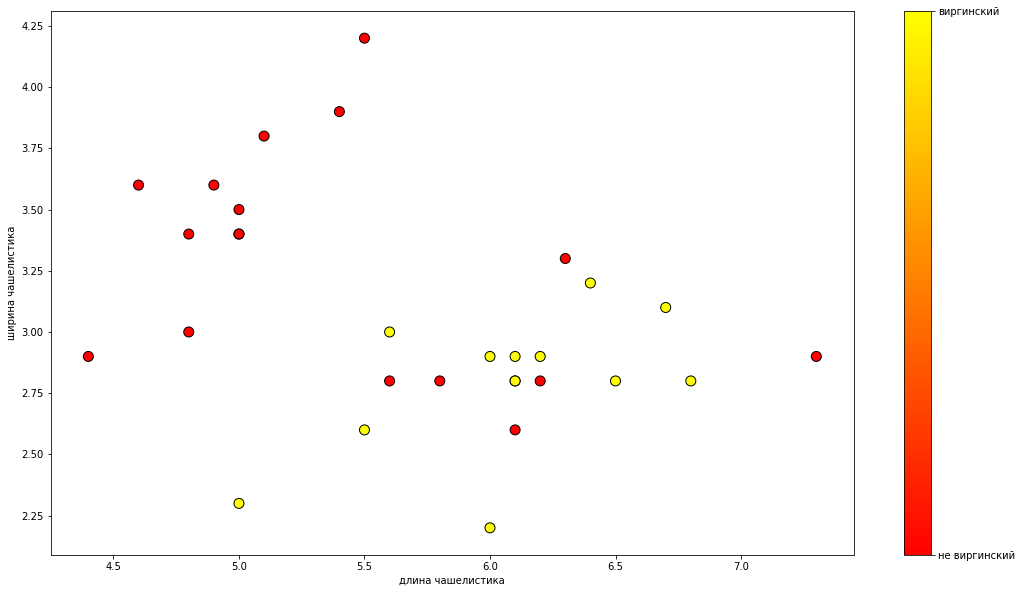

In [52]:
plt.figure(figsize=(18.0, 10.0))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=100, cmap='autumn', edgecolors="black")
plt.xlabel(features[0])
plt.ylabel(features[1])
show_legend()

Обучим логистическую регрессию:

In [53]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, C=1.0).fit(X_train, y_train)
clf.predict(X_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [54]:
# score(X, y[, sample_weight]) — Return the mean accuracy on the given test data and labels.
clf.score(X_test, y_test)

0.6333333333333333

Построим ROC-кривую:

In [55]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], drop_intermediate=False)

In [56]:
fpr, tpr

(array([0.        , 0.        , 0.        , 0.        , 0.05882353,
        0.11764706, 0.17647059, 0.17647059, 0.23529412, 0.23529412,
        0.23529412, 0.29411765, 0.29411765, 0.29411765, 0.29411765,
        0.35294118, 0.41176471, 0.41176471, 0.41176471, 0.41176471,
        0.47058824, 0.52941176, 0.64705882, 0.70588235, 0.76470588,
        0.82352941, 0.88235294, 0.94117647, 1.        ]),
 array([0.        , 0.07692308, 0.15384615, 0.23076923, 0.23076923,
        0.23076923, 0.23076923, 0.38461538, 0.38461538, 0.46153846,
        0.53846154, 0.53846154, 0.61538462, 0.69230769, 0.76923077,
        0.76923077, 0.76923077, 0.84615385, 0.92307692, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]))

In [57]:
thresholds

array([1.71289328, 0.71289328, 0.67124341, 0.51102189, 0.50747759,
       0.40206465, 0.40092868, 0.39922672, 0.39865994, 0.39696123,
       0.395265  , 0.35713844, 0.34850326, 0.34796678, 0.34743069,
       0.34155941, 0.30649415, 0.30248961, 0.25336008, 0.21534873,
       0.18095105, 0.15528168, 0.1546626 , 0.12810819, 0.10643964,
       0.10576709, 0.07056419, 0.05708437, 0.03033316])

Значительная часть точек ROC-кривой бесполезна и можно их удалить:

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], drop_intermediate=True)

In [60]:
fpr, tpr

(array([0.        , 0.        , 0.        , 0.17647059, 0.17647059,
        0.23529412, 0.23529412, 0.29411765, 0.29411765, 0.41176471,
        0.41176471, 0.52941176, 0.64705882, 1.        ]),
 array([0.        , 0.07692308, 0.23076923, 0.23076923, 0.38461538,
        0.38461538, 0.53846154, 0.53846154, 0.76923077, 0.76923077,
        1.        , 1.        , 1.        , 1.        ]))

In [61]:
thresholds

array([1.71289328, 0.71289328, 0.51102189, 0.40092868, 0.39922672,
       0.39865994, 0.395265  , 0.35713844, 0.34743069, 0.30649415,
       0.21534873, 0.15528168, 0.1546626 , 0.03033316])

ROC-кривая:

Text(0, 0.5, 'tpr')

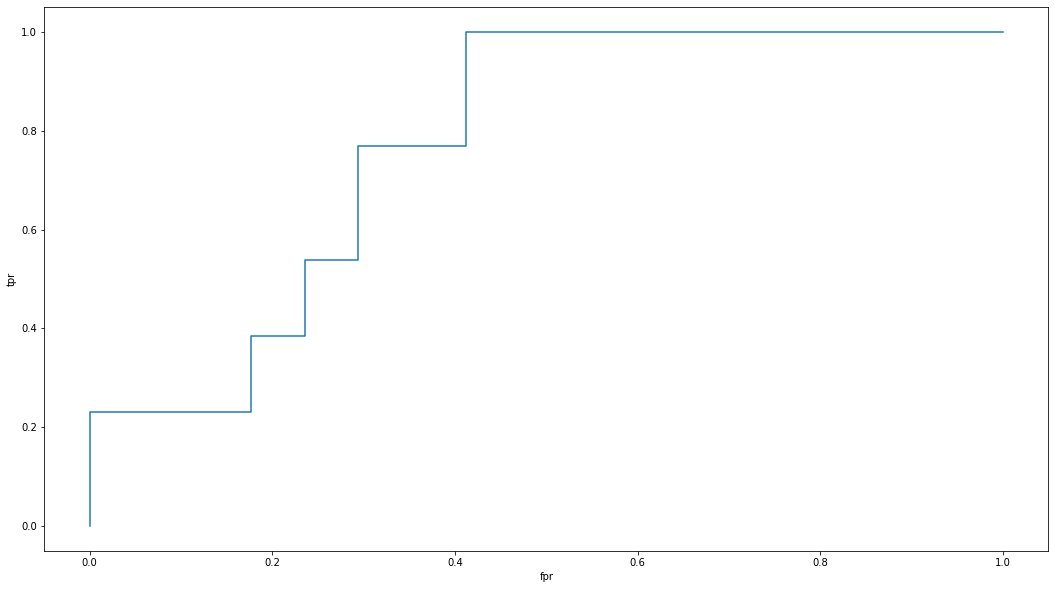

In [62]:
plt.figure(figsize=(18.0, 10.0))
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")

Посчитаем ROC-auc

In [92]:
round(auc(fpr, tpr), ndigits=3)

NameError: name 'auc' is not defined

## Precision-recall кривая

Аналогично строим precision-recall кривую

In [65]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])

Text(0, 0.5, 'precision')

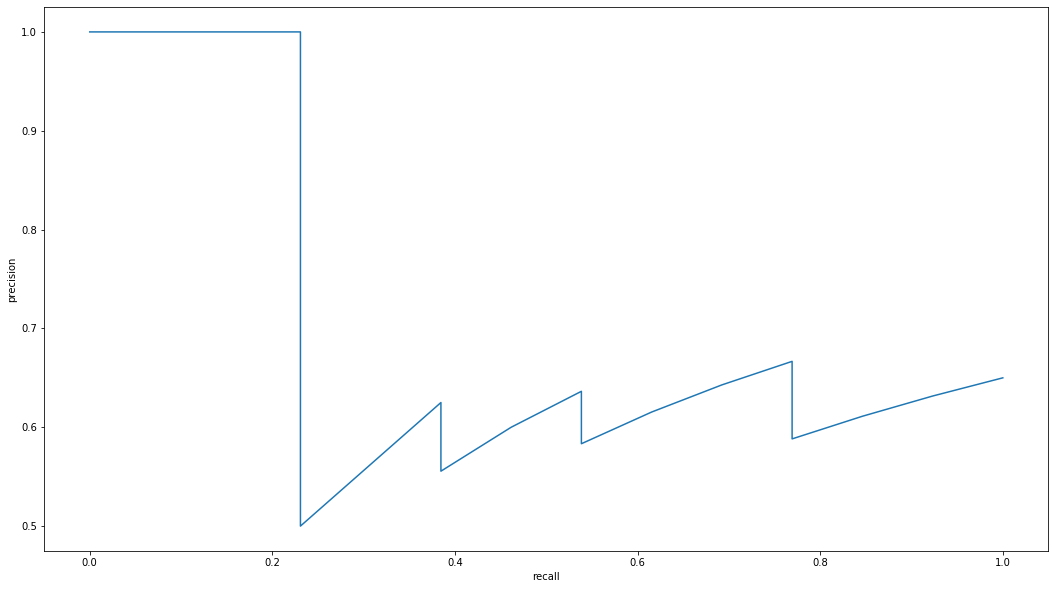

In [66]:
plt.figure(figsize=(18.0, 10.0))
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")

И вычисляем PR-AUC

In [67]:
auc(recall, precision)

0.6973853122876699